# Feature Vector Calculations
The goal of this file is to be able to take in a sound observation (obtained from onset-/tempo-based windowing) and return a 1D vector that characterizes the sound. The different characteristics are listed in the Sound.py class.

In [1]:
import numpy as np
import librosa as lb
import matplotlib.pyplot as plt
import IPython.display as ipd
import scipy.io as sio
import miscFuns as mf

In [2]:
sr_native = 44100 # Native audio sample rate
sr = int(sr_native/4) # Heavily downsampled for onset detection

In [3]:
audio1, sr1 = lb.load('audio_data\scozier_rec1.wav', sr=sr_native)
audio2, sr2 = lb.load('audio_data\scozier_rec1.wav', sr=int(sr_native/2))
audio4, sr4 = lb.load('audio_data\scozier_rec1.wav', sr=int(sr_native/4))
audio10, sr10 = lb.load('audio_data\scozier_rec1.wav', sr=int(sr_native/10))

In [4]:
def envelope(sound, M=20, sr=sr):
    ''' Generates 1-sided sound envelope based on simple moving averaging method. In order to track the sound
        onset better, the averaging window is biased towards the past data points, rather than centered
        around the current point.
        
        @param sound  sound observation in time-energy domain
        @param M      1/3 of window size of moving average (window from n-2M to n+M)
    '''
    
    #### NEW METHOD ######
#     sound = np.array(list(map(mf.halfWave, sound)))
    
#     retain only the peaks (filter?)
#     use linear interpolation between the points
#     ignore any pre-peak valleys (may not be necessary?)

#     Ask Prof. Tsai about using autocorrelation for this
    
    #### OLD METHOD ######
    
    sound = np.abs(sound)
        
    for frame in np.arange(len(sound)):
        start = max(0,frame-2*M) # Bias window towards past data
        end = min(len(sound)-1, frame+M)
        sound[frame] = sum(sound[start:end])/(max(end-start,1)) 
    
    return sound    

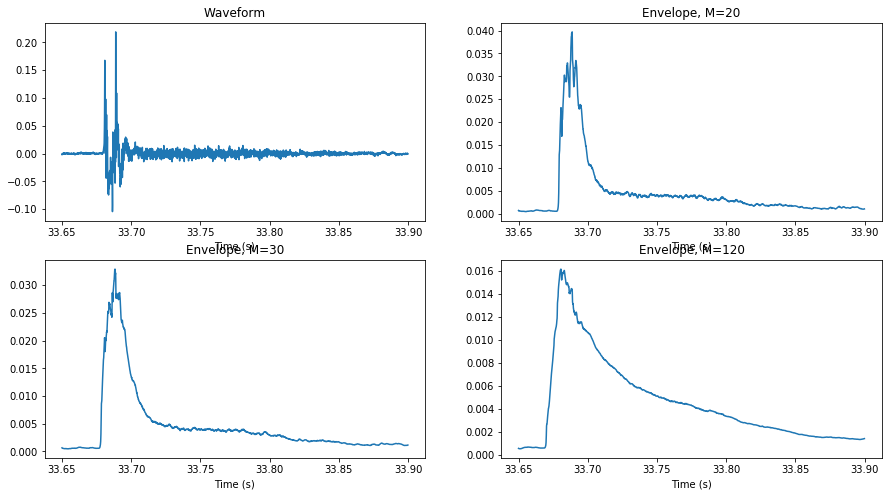

[428, 427, 422, 337]
[0.03882086 0.03873016 0.03827664 0.03056689]


In [50]:
audio = audio4; sr = sr4

t = [33.65, 33.9]
# ^Ksh: 33.65, 33.9
# B: 3.67, 3.85
# t: 57.725, 58

plt.figure(1, figsize=[15,8])
plt.subplot(2,2,1)
short_audio = mf.plotWave(audio4, t, sr=sr, short=True, title='Waveform')
peaks = [np.argmax(short_audio)]

# strength_env = lb.onset.onset_strength(short_audio, sr=sr)
sound_env = envelope(short_audio, M=20)
peaks += [np.argmax(sound_env)]

plt.subplot(2,2,2)
mf.plotWave(sound_env, t0=t[0], sr=sr, title='Envelope, M=20')

sound_env = envelope(short_audio, M=30)
peaks += [np.argmax(sound_env)]

plt.subplot(2,2,3)
mf.plotWave(sound_env, t0=t[0], sr=sr, title='Envelope, M=30')

sound_env = envelope(short_audio, M=120)
peaks += [np.argmax(sound_env)]

plt.subplot(2,2,4)
mf.plotWave(sound_env, t0=t[0], sr=sr, title='Envelope, M=120')

# plt.subplot(1,3,3)
# plotWave(strength_env, t0=t[0], title='Strength Envelope')

plt.show()

print(peaks)
print(np.array(peaks)/sr)


In [67]:
def calcADSR(sound, env, sr=sr):
    ''' sound is the time-energy representation (raw audio data)
        x variables are in samples, t variables are in seconds
        
        This function assumes that the sound has been windowed appropriately
        such that the first index is the beginning of the sound.
        
        I categorized sounds into 2 categories based on the severity of release.
        If the post-decay section is a gradual release, this counts it as 0 sustain and full release.
        IF the post-decay section is followed by a hard release section, both sustain and release will be positive.
    '''
    
    thresh = 0.001 # Minimum sound level (envelope)
    min_slope = 3e-6 # minimum slope threshold (for steady state vs. release)
    slope_run = int(0.1*sr) # Step width for average slope calculation
    
    len_smp = len(env)
    
#     x_peak = argmax(sound) # Should this be used?
    x_peak_env = np.argmax(env)
    
    # Initialize variables
    x_start = 0
    x_end = len(sound)-1
    
    # Look for start of sound
    for x,eVal in enumerate(env):
        if eVal > thresh: # Start of sound
            x_start = x
            break
    
    # Look for post-peak decay, sustain, and release.
    x_ss1 = x_ss2 = x_peak_env
    inDecay = True
    for x,eVal in enumerate(env[x_peak_env:]):
        x += x_peak_env
        slope = (env[min(x+slope_run, x_end)]-env[x])/(min(x+slope_run, x_end) - x)
#         print([x/sr+t[0],slope])

        if (eVal < thresh) or (x == x_end-1): # End of sound
            x_end = x # Minor off-by-one error?           
            break
            
        elif inDecay and (np.abs(slope) < min_slope): # Start of a sustain/gradual release section
            x_ss1 = x_ss2 = x # Initialize x_ss2 in case of no hard release
            inDecay = False
        elif (inDecay==False) and (np.abs(slope) >= min_slope): # Start of a hard release
            x_ss2 = x
            
    print('x_start: {}, x_peak_env: {}, x_ss1: {}, x_ss2: {}, x_end: {}'.format(x_start, x_peak_env, x_ss1, x_ss2, x_end))
    attack = (x_peak_env-x_start)/sr
    decay = (x_ss1-x_peak_env)/sr 
    sustain = (x_ss2-x_ss1)/sr 
    release = (x_end-1-x_ss2)/sr
    
    return attack, decay, sustain, release

x_start: 313, x_peak_env: 427, x_ss1: 653, x_ss2: 2741, x_end: 2742
x_start: 296, x_peak_env: 427, x_ss1: 784, x_ss2: 2753, x_end: 2754
x_start: 277, x_peak_env: 425, x_ss1: 879, x_ss2: 2753, x_end: 2754
x_start: 258, x_peak_env: 427, x_ss1: 921, x_ss2: 2753, x_end: 2754
ADSR values for varying envelope window sizes:
[[0.01034014 0.02049887 0.18938776 0.        ]
 [0.01188209 0.03238095 0.1785941  0.        ]
 [0.01342404 0.04117914 0.16997732 0.        ]
 [0.0153288  0.04480726 0.1661678  0.        ]]


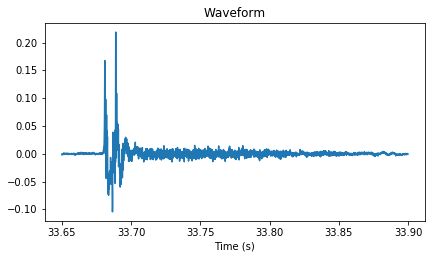

In [68]:
plt.figure(1, figsize=[15,8])
plt.subplot(2,2,1)
short_audio = mf.plotWave(audio4, t, sr=sr, short=True, title='Waveform')

adsr = np.zeros((4,4))
for n, M in enumerate([20,40,60,80]):
    sound_env = envelope(short_audio, M)
    attack, decay, sustain, release = calcADSR(short_audio, sound_env)
    adsr[n,:] = np.array([attack, decay, sustain, release])

print('ADSR values for varying envelope window sizes:')
print(adsr)